# <center>  Python for biologists
    
## Homework 11, Visualisation



## Правила

- **Не создавайте доп. веток в репозитории, не копируйте ноутбук.**
- Пишите код только там, где это от вас требуется (`# YOUR CODE HERE`)
- Не переименовывайте переменные, если они уже созданы. Происходят автопроверки.
- Перед отправкой проверьте что ваш ноутбук работает (юпитер-ноутбук). Нажмите на панели сверху `Kernel` -> `Restart Kernel and Run All Cells...`. Проверье что нет ошибок.
    

#### Погнали!

---


In [68]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from io import BytesIO
import matplotlib.image as mpimg

# здесь любые импорты которые вам еще понадобятся (только здесь)

# Построение графиков по биоинформатическим данным

## Heatmap

- Данные: `DE_data_1.tsv`

<img src="heatmap.png" align="center" width="500" >

In [91]:
# Это мета-информация об образцах
meta = pd.DataFrame({'ENCFF240NOH': ('TAP pre-treated', 1),
                     'ENCFF245SJH': ('TAP pre-treated', 2),
                     'ENCFF321FEM': ('No treat', 1),
                     'ENCFF368OTJ': ('No treat', 2),
                     'ENCFF711LJB': ('AP-TAP pre-treated', 1),
                     'ENCFF826APU': ('AP-TAP pre-treated', 2)}, index=['Sample', 'Replicate']).T
meta

,Sample,Replicate
ENCFF240NOH,TAP pre-treated,1
ENCFF245SJH,TAP pre-treated,2
ENCFF321FEM,No treat,1
ENCFF368OTJ,No treat,2
ENCFF711LJB,AP-TAP pre-treated,1
ENCFF826APU,AP-TAP pre-treated,2


<Figure size 1200x1000 with 0 Axes>

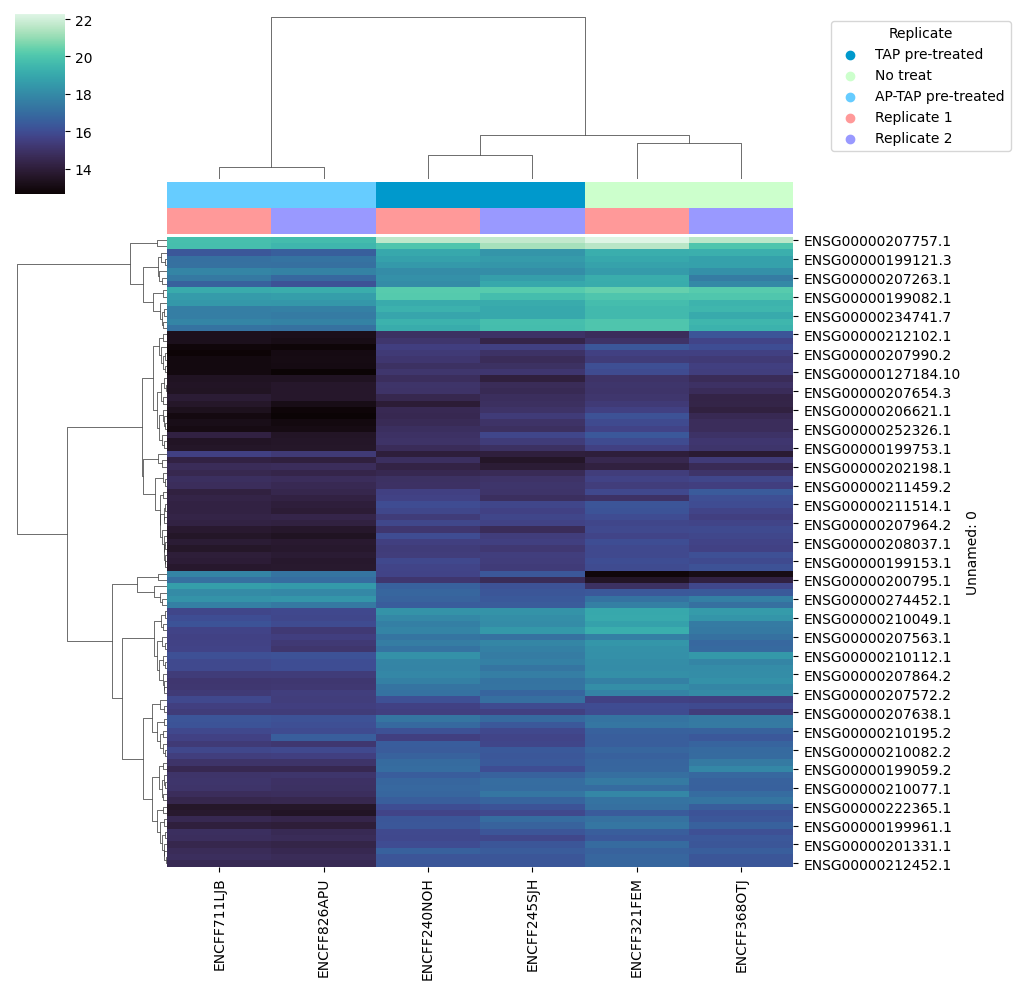

<Figure size 640x480 with 0 Axes>

In [104]:
# Загрузка данных
data = pd.read_csv('DE_data_1.tsv', sep='\t')
data.set_index('Unnamed: 0', inplace=True)
# Вычисление суммарной экспрессии и выбор топ-100 генов
sum_expression = data.sum(axis=1)
top_100_genes = sum_expression.sort_values(ascending=False).head(100).index
filtered_data = data.loc[top_100_genes]
# Назначение цветов для каждого типа образца
sample_colors = ['#0099CC', '#CCFFCC', '#66CCFF', '#7247D7', '#8D6DD7']
color_dict = dict(zip(meta['Sample'].unique(), sample_colors))
replicate_color_dict = {'1': '#FF9999', '2': '#9999FF'}  # Цвета для репликатов 1 и 2
replicate_col_colors = meta['Replicate'].map(lambda x: replicate_color_dict[str(x)])
# Создание списка цветов для аннотации столбцов
col_colors = meta['Sample'].map(color_dict)
# Назначение цветов для репликат
replicate_colors = ['#FF9999', '#9999FF']
replicate_color_dict = dict(zip(meta['Replicate'].unique(), replicate_colors))
# Создание списка цветов для аннотации репликат
replicate_col_colors = meta['Replicate'].map(replicate_color_dict)
# Построение тепловой карты
plt.figure(figsize=(12, 10))
g = sns.clustermap(filtered_data, method='ward', metric='euclidean', cmap='mako', col_cluster=True, row_cluster=True, col_colors=[col_colors, replicate_col_colors])
# Перемещение легенды типов образцов в правый верхний угол
for sample_type, color in color_dict.items():
    plt.scatter([], [], color=color, label=sample_type)
plt.legend(title='Sample Type', bbox_to_anchor=(1.05, 1), loc='upper left')
# Добавление легенды для репликат
for replicate, color in replicate_color_dict.items():
    plt.scatter([], [], color=color, label=f"Replicate {replicate}")
plt.legend(title='Replicate', bbox_to_anchor=(20.05, 1.0), loc='upper right')
plt.show()

## Volcano plot

- Данные: `DE_data_2.gz`

<img src="volcano_plot.png" align="center" width="500" >

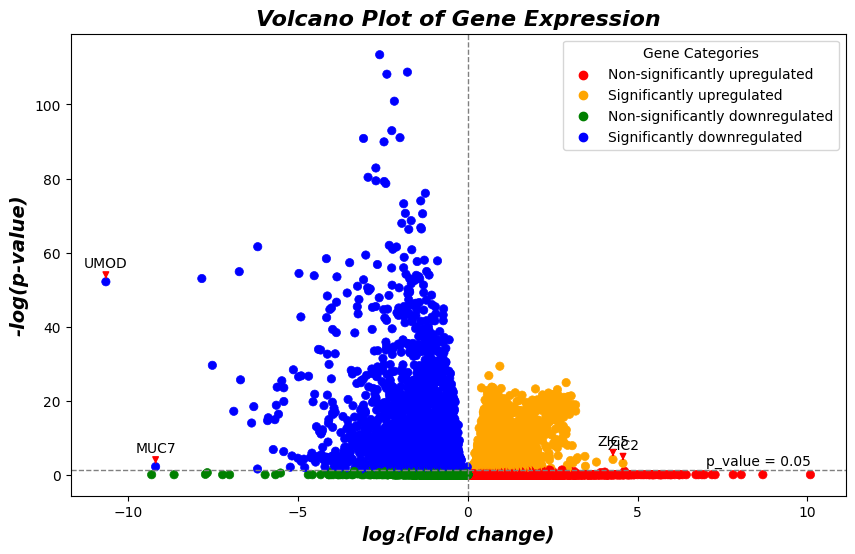

In [94]:
# Загрузка данных
data = pd.read_csv('DE_data_2.gz', delimiter='\t')
# Определение порога значимости
p_value_threshold = 0.05
log_p_value_threshold = -np.log10(p_value_threshold)
# Категоризация данных
data['Category'] = 'Non-significantly upregulated'  # Значение по умолчанию
data.loc[(data['log_pval'] > log_p_value_threshold) & (data['logFC'] > 0), 'Category'] = 'Significantly upregulated'
data.loc[(data['log_pval'] > log_p_value_threshold) & (data['logFC'] < 0), 'Category'] = 'Significantly downregulated'
data.loc[(data['log_pval'] <= log_p_value_threshold) & (data['logFC'] < 0), 'Category'] = 'Non-significantly downregulated'
# Цвета для категорий
category_colors = {
    'Significantly upregulated': 'orange',
    'Significantly downregulated': 'blue',
    'Non-significantly upregulated': 'red',
    'Non-significantly downregulated': 'green'
}
# Настройка вулкано-плота
plt.figure(figsize=(10, 6))
sns.scatterplot(data=data, x="logFC", y='log_pval', hue='Category', palette=category_colors, edgecolor=None)
# Размещение легенды с тенью
leg = plt.legend(title='Gene Categories', loc='upper right', bbox_to_anchor=(1, 1))
leg_shadow = plt.gca().add_patch(plt.Rectangle((2, 1), 2, 2, transform=leg.get_frame().get_transform(),
                                  fc='black', zorder=2, alpha=0.3))
# Аннотация генов с красными стрелками и чёрной гранью
top_upregulated_genes = data[data['Category'] == 'Significantly upregulated'].nlargest(2, 'logFC')
top_downregulated_genes = data[data['Category'] == 'Significantly downregulated'].nsmallest(2, 'logFC')
for i, row in pd.concat([top_upregulated_genes, top_downregulated_genes]).iterrows():
    plt.annotate(row['Sample'], (row['logFC'], row['log_pval']), xytext=(0, 10), textcoords='offset points',
                 arrowprops=dict(arrowstyle="-|>", color='red', lw=1), fontsize=10, ha='center')
# Разметка для p_value
plt.text(x=data['logFC'].max(), y=1.8, s='p_value = 0.05', horizontalalignment='right', verticalalignment='bottom', fontsize=10)
# Оси и заголовок
plt.xlabel('log\u2082(Fold change)', fontweight='bold', fontstyle='italic', fontsize=14)
plt.ylabel('-log(p-value)', fontweight='bold', fontstyle='italic', fontsize=14)
plt.title('Volcano Plot of Gene Expression', fontweight='bold', fontstyle='italic', fontsize=16)
# Настройка осей
plt.axhline(y=log_p_value_threshold, color='grey', linestyle='--', linewidth=1)
plt.axvline(x=0, color='grey', linestyle='--', linewidth=1)
# Отображение графика
plt.show()

## Сохранение графиков

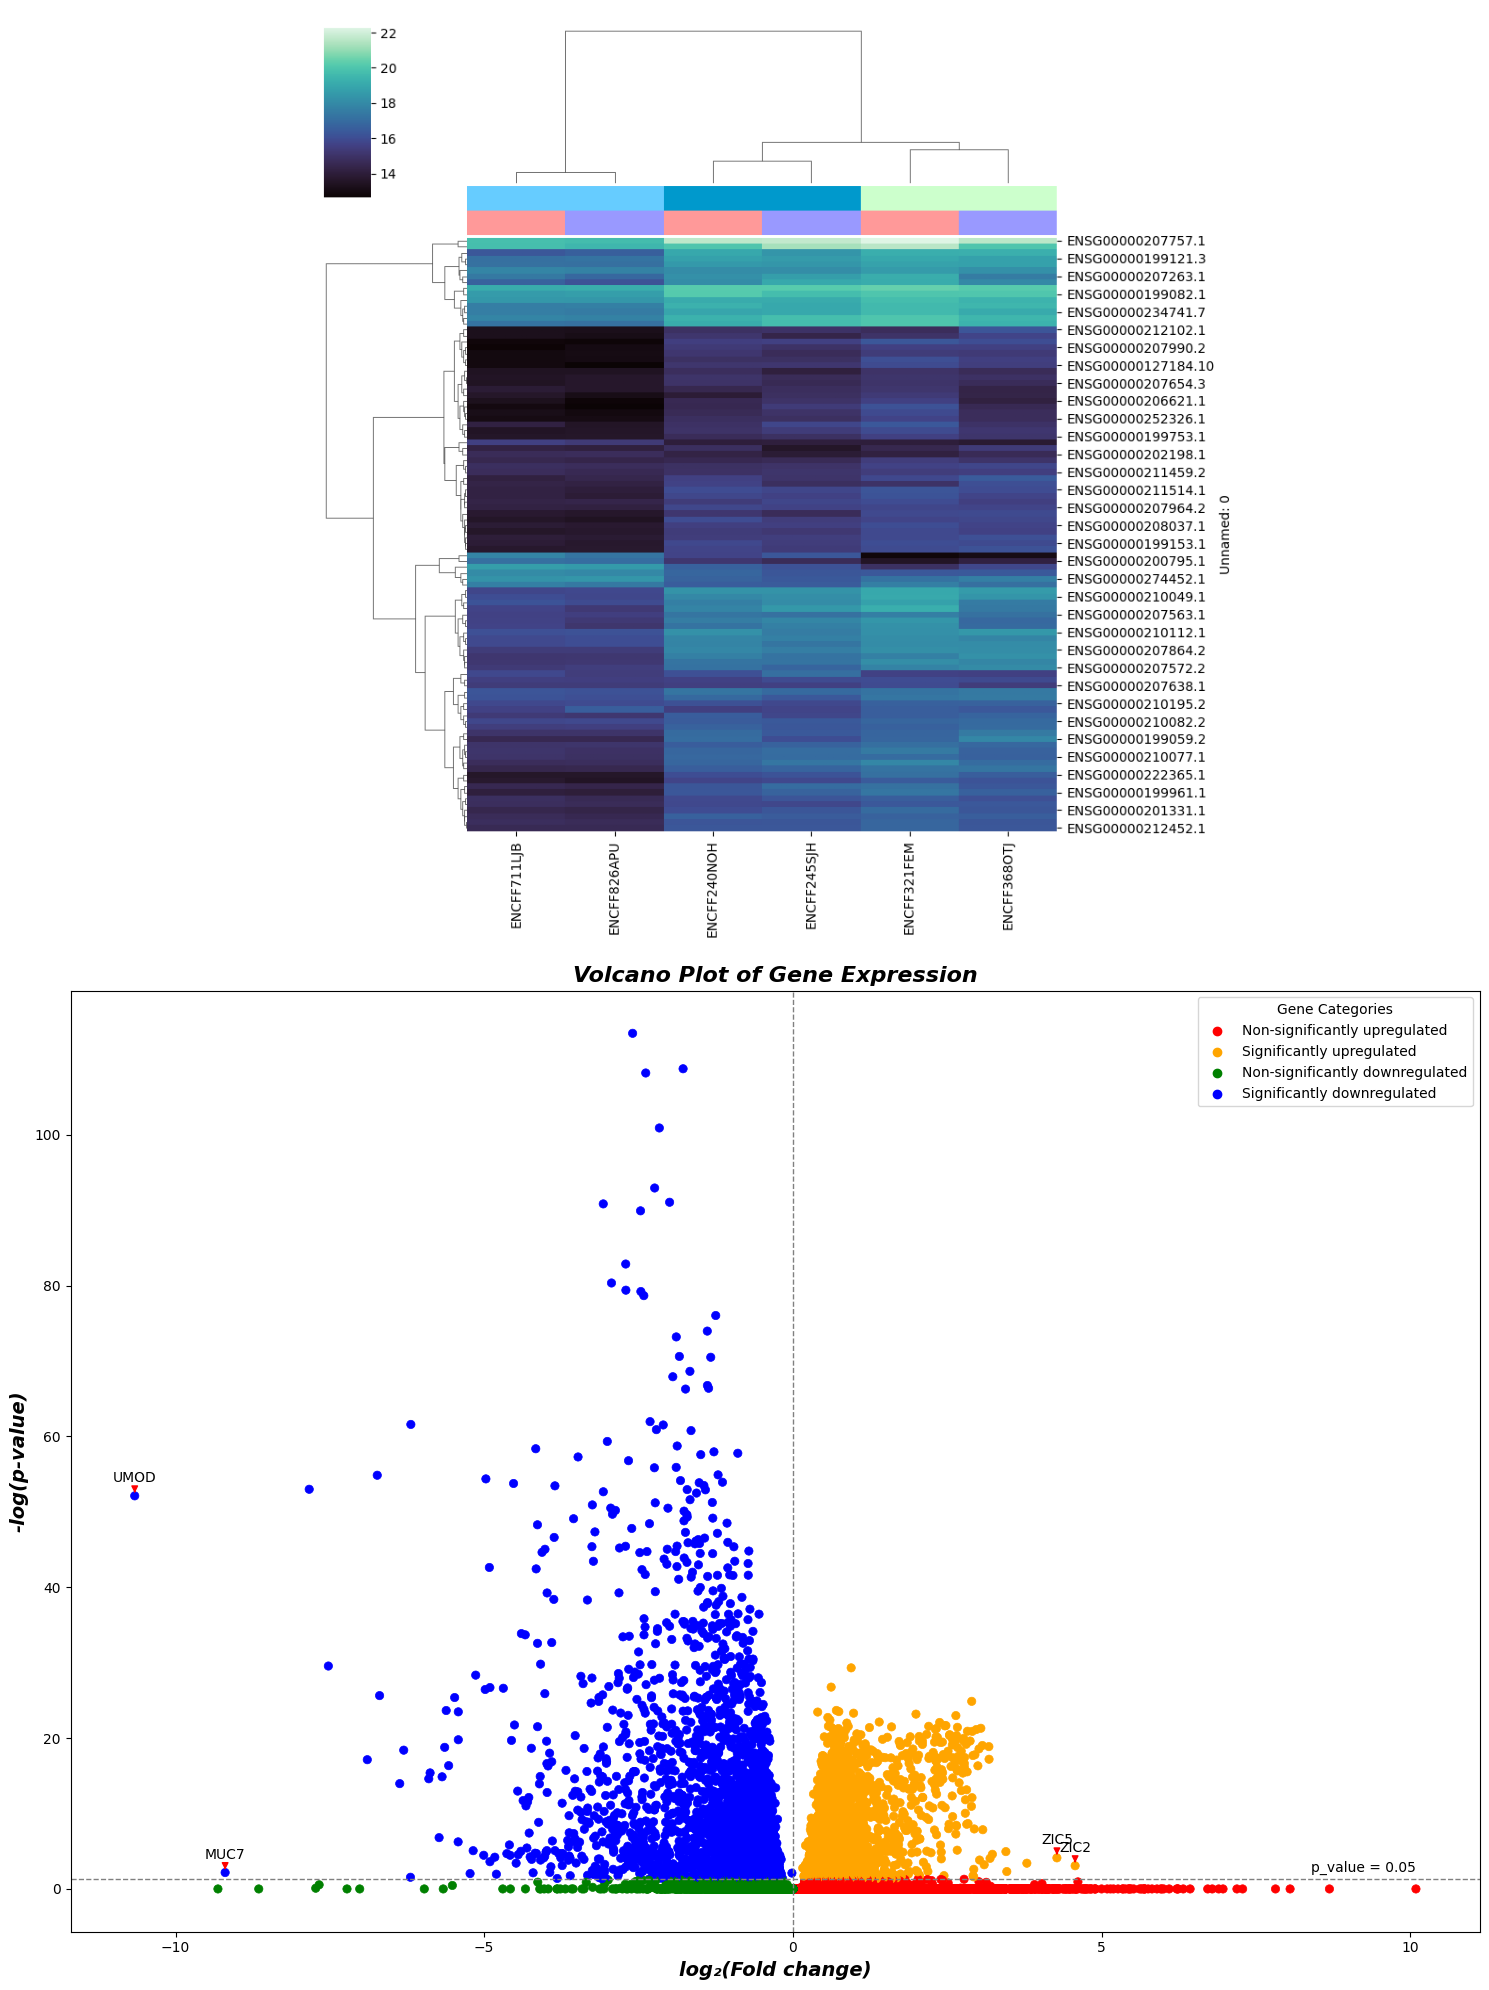

In [124]:
# Создание фигуры с двумя подграфиками
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(15, 20))
# Первый график (тепловая карта)
# Сохранение тепловой карты в виртуальный файл
virtual_file = BytesIO()
g = sns.clustermap(filtered_data, method='ward', metric='euclidean', cmap='mako', col_cluster=True, row_cluster=True, col_colors=[col_colors, replicate_col_colors])
plt.savefig(virtual_file, format='png')
plt.close(g.fig)
# Загрузка изображения из виртуального файла и отображение его на подграфике
virtual_file.seek(0)
heat_map_image = mpimg.imread(virtual_file)
axes[0].imshow(heat_map_image)
axes[0].axis('off')
# Второй график (вулкано-плот)
sns.scatterplot(data=data, x="logFC", y='log_pval', hue='Category', palette=category_colors, edgecolor=None)
leg = plt.legend(title='Gene Categories', loc='upper right', bbox_to_anchor=(1, 1))
leg_shadow = plt.gca().add_patch(plt.Rectangle((2, 1), 2, 2, transform=leg.get_frame().get_transform(),
                                  fc='black', zorder=2, alpha=0.3))
top_upregulated_genes = data[data['Category'] == 'Significantly upregulated'].nlargest(2, 'logFC')
top_downregulated_genes = data[data['Category'] == 'Significantly downregulated'].nsmallest(2, 'logFC')
for i, row in pd.concat([top_upregulated_genes, top_downregulated_genes]).iterrows():
    plt.annotate(row['Sample'], (row['logFC'], row['log_pval']), xytext=(0, 10), textcoords='offset points',
                 arrowprops=dict(arrowstyle="-|>", color='red', lw=1), fontsize=10, ha='center')
plt.text(x=data['logFC'].max(), y=1.8, s='p_value = 0.05', horizontalalignment='right', verticalalignment='bottom', fontsize=10)
plt.xlabel('log\u2082(Fold change)', fontweight='bold', fontstyle='italic', fontsize=14)
plt.ylabel('-log(p-value)', fontweight='bold', fontstyle='italic', fontsize=14)
plt.title('Volcano Plot of Gene Expression', fontweight='bold', fontstyle='italic', fontsize=16)
plt.axhline(y=log_p_value_threshold, color='grey', linestyle='--', linewidth=1)
plt.axvline(x=0, color='grey', linestyle='--', linewidth=1)
# Сохранение фигуры
plt.tight_layout()
plt.savefig('combined_figure.png', dpi=300)
# Отображение фигуры
plt.show()

---
# EDA

Покажите тут, что у вас получилось!

> По идее, вам нужно только запустить ячейку и всё. Но можете изменить датасет если хотите.

In [73]:
# Можете вставить любой репрезентативный дата-фрейм на ваше усмотрение :)
data_dir = 'https://raw.githubusercontent.com/Python-BI-2023/course_materials/main/data/'
df = pd.read_csv(data_dir + 'titanic.csv')

In [ ]:
import pandas as pd
from IPython.display import display
import matplotlib.pyplot as plt
import seaborn as sns

Welcome to the EDA of your DataFrame!
Number of observations (rows): 418
Number of features (columns): 11
Data types of each column:
PassengerId      int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object
Numeric columns: Index(['PassengerId', 'Age', 'Fare'], dtype='object')
Categorical columns: Index(['Name', 'Sex', 'Ticket', 'Cabin', 'Embarked', 'Pclass', 'SibSp',
       'Parch'],
      dtype='object')
String columns (excluded from analysis): Index([], dtype='object')
Analysis of Name:


,Counts,Percentage
"Kelly, Mr. James",1,0.002392
"Carr, Miss. Jeannie",1,0.002392
"Dennis, Mr. William",1,0.002392
"Rosblom, Miss. Salli Helena",1,0.002392
"Touma, Miss. Maria Youssef",1,0.002392
...,...,...
"Zakarian, Mr. Mapriededer",1,0.002392
"Carlsson, Mr. Carl Robert",1,0.002392
"Dintcheff, Mr. Valtcho",1,0.002392
"Thomas, Mr. Charles P",1,0.002392


Analysis of Sex:


,Counts,Percentage
male,266,0.636364
female,152,0.363636


Analysis of Ticket:


,Counts,Percentage
PC 17608,5,0.011962
CA. 2343,4,0.009569
113503,4,0.009569
PC 17483,3,0.007177
220845,3,0.007177
...,...,...
349226,1,0.002392
2621,1,0.002392
4133,1,0.002392
113780,1,0.002392


Analysis of Cabin:


,Counts,Percentage
B57 B59 B63 B66,3,0.032967
B45,2,0.021978
C89,2,0.021978
C55 C57,2,0.021978
A34,2,0.021978
...,...,...
E52,1,0.010989
D30,1,0.010989
E31,1,0.010989
C62 C64,1,0.010989


Analysis of Embarked:


,Counts,Percentage
S,270,0.645933
C,102,0.244019
Q,46,0.110048


Analysis of Pclass:


,Counts,Percentage
3,218,0.521531
1,107,0.255981
2,93,0.222488


Analysis of SibSp:


,Counts,Percentage
0,283,0.677033
1,110,0.263158
2,14,0.033493
3,4,0.009569
4,4,0.009569
8,2,0.004785
5,1,0.002392


Analysis of Parch:


,Counts,Percentage
0,324,0.775120
1,52,0.124402
2,33,0.078947
3,3,0.007177
4,2,0.004785
9,2,0.004785
6,1,0.002392
5,1,0.002392


,PassengerId,Age,Fare
count,418.00,332.00,417.00
mean,1100.50,30.27,35.63
std,120.81,14.18,55.91
min,892.00,0.17,0.00
25%,996.25,21.00,7.90
50%,1100.50,27.00,14.45
75%,1204.75,39.00,31.50
max,1309.00,76.00,512.33


Number of outliers in PassengerId: 0
Number of outliers in Age: 2
Number of outliers in Fare: 55
Total missing values: 414
Rows with missing values: 331
Columns with missing values: ['Age', 'Fare', 'Cabin']
Number of duplicate rows: 0


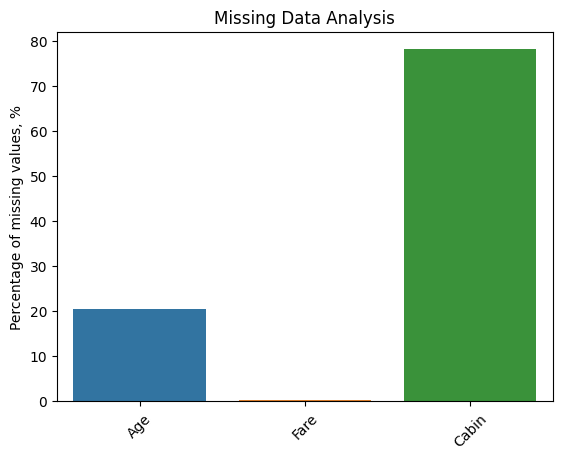

<ipython-input-81-e43b5aaecdb8>:62: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = df.corr()


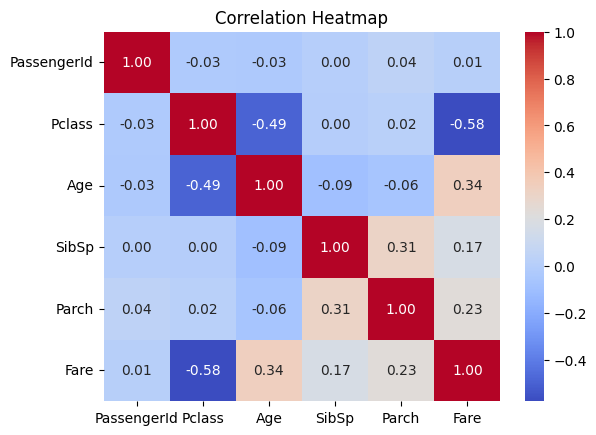

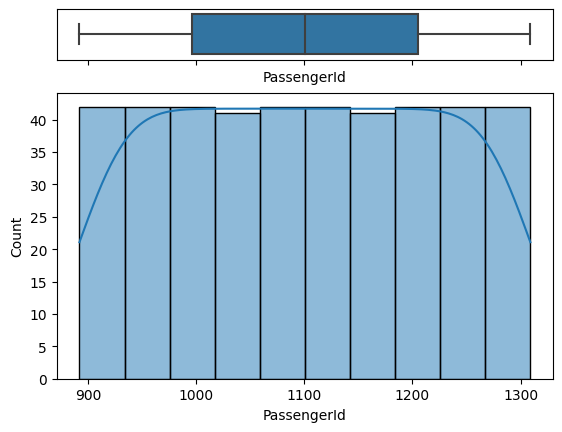

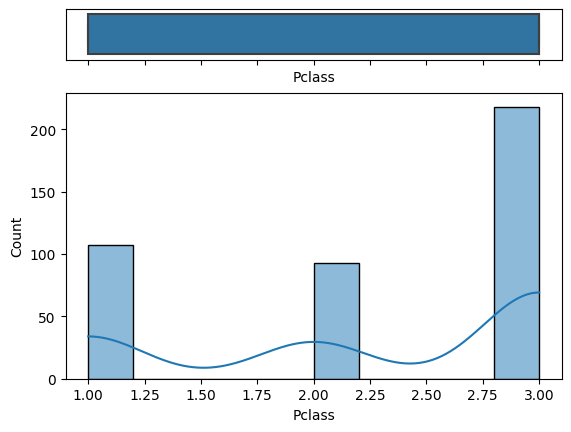

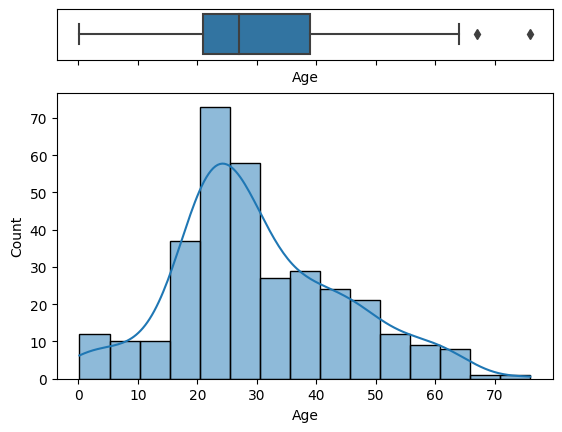

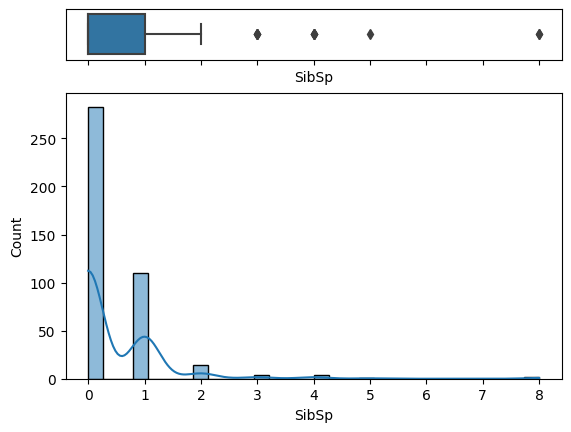

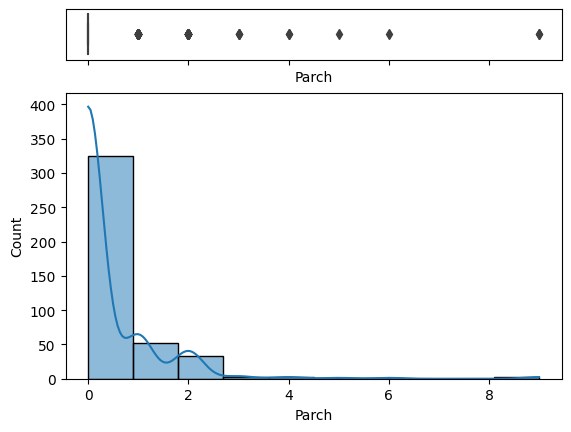

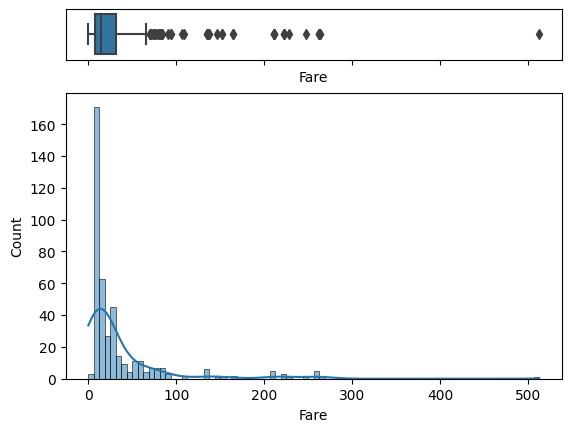

In [81]:
from my_awesome_eda import run_eda

run_eda(df)
plot_missing_values(df)
plot_correlation_heatmap(df)
plot_hist_box(df)